In [1]:
import numpy as np
import os
import random
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
import pathlib
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

In [2]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
raw_data_path           = os.path.join(parent_path, "data/raw/training/")

In [3]:
# Reading the data oldschool like
data = []
groundtruth = []
Files = ['groundtruth', 'images']

for files in Files:
    cpath = os.path.join(raw_data_path, files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        if files=="images":
            data.append(image_array)
        else:
            groundtruth.append(image_array)
images = np.array(data)
masks =  np.array(groundtruth)

In [4]:
def some_vals(images,masks):
    print("Shape Images: "+str(images.shape))
    print("Shape Masks: "+str(masks.shape))
    print("Max Images: "+str(np.max(images)))
    print("Max Masks: "+str(np.max(masks)))
    print("Min Images: "+str(np.min(images)))
    print("Min Masks: "+str(np.min(masks)))

In [5]:
some_vals(images,masks)

Shape Images: (144, 400, 400, 3)
Shape Masks: (144, 400, 400, 3)
Max Images: 255
Max Masks: 255
Min Images: 0
Min Masks: 0


In [6]:
# import albumentations as A
# original_height, original_width = 400,400
# aug = A.Compose([
#     A.OneOf([
#         A.RandomSizedCrop(min_max_height=(200, 300), height=original_height, width=original_width, p=0.5),
#         A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
#     ], p=1),    
#     A.VerticalFlip(p=0.5),              
#     A.RandomRotate90(p=0.5),
# #     A.OneOf([
# #         A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
# #         A.GridDistortion(p=0.5),
# #         A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
# #         ], p=0.8),
#     A.CLAHE(p=0.8),
#     A.RandomBrightnessContrast(p=0.8),    
#     A.RandomGamma(p=0.8)])

In [7]:
import albumentations as A
img_size = 128
batch_size = 32
aug = A.Compose([
        A.RandomCrop(width = img_size, height = img_size, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        A.RandomBrightnessContrast(p=0.25),
        A.RandomGamma(p=0.25),
        A.IAAEmboss(p=0.25),
        A.Blur(p=0.01, blur_limit = 3),
#         A.OneOf([
#             A.ElasticTransform(p=0.5, alpha=400, sigma=400 * 0.05, alpha_affine=400 * 0.03),
#             A.GridDistortion(p=0.5),
#             A.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.1)                  
#         ], p=0.8)
    ], p = 1)
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask/255.0, tf.float32)
    return input_image, input_mask
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image.numpy(), input_mask.numpy()
def augment(input_image, input_mask):
    data = {"image":input_image,"mask":input_mask}
    aug_data = aug(**data)
    input_image = aug_data["image"]
    input_mask = aug_data["mask"]
    return input_image, input_mask
def set_shapes(input_image, input_mask, img_shape=(None,img_size,img_size,3),mas_shape=(None,img_size,img_size,1)):
    input_image.set_shape(img_shape)
    input_mask.set_shape(mas_shape)
    return input_image, input_mask
def load_image_train(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
#     input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
#     input_image, input_mask = set_shapes(input_image, input_mask)
    return input_image, input_mask
def load_image_test(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
#     input_image, input_mask = set_shapes(input_image, input_mask)
    return input_image, input_mask
def train_prepro(image, mask, img_size):
    aug_img,aug_mask = tf.numpy_function(func=load_image_train, inp=[image, mask], Tout=[tf.float32,tf.float32])
    return aug_img, aug_mask
def test_prepro(image, mask, img_size):
    image,mask = tf.numpy_function(func=load_image_test, inp=[image, mask], Tout=[tf.float32,tf.float32])
    return image, mask

C:\Users\guthr\anaconda\envs\road\lib\site-packages\albumentations\imgaug\transforms.py:175: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [8]:
from enum import Enum
from tqdm import tqdm
# mask color codes
class MaskColorMap(Enum):
    Other = (0, 0, 0)
    Road = (255, 255, 255)

def integer_encoded_mask(masks):

    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1))

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return np.array(integer_encoded_labels).astype(int)
masks_ohe = integer_encoded_mask(masks)

100%|███████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 121.59it/s]


In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(images,masks_ohe*255,test_size=0.1,random_state=42)
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
test_ds = (tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE=1000
from functools import partial
# create dataset
train_dataset = train_ds.map(partial(train_prepro, img_size=img_size),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(batch_size).repeat()
test_dataset = test_ds.map(partial(test_prepro, img_size=img_size),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).batch(3).repeat()
train_batches = train_dataset.map(set_shapes)
validation_batches = test_dataset.map(set_shapes)

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

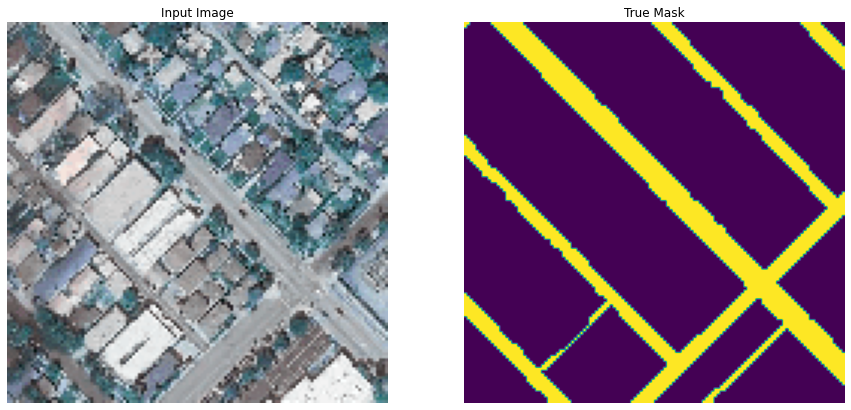

In [12]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [13]:
img, mas = next(iter(train_batches))

In [14]:
train_batches

<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [15]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [16]:
def build_unet_model(img_size):

    # inputs
    inputs = layers.Input(shape=(img_size,img_size,3))
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [17]:
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
save_path = "./save/baseline"
if save_path==save_path:
    try:
        shutil.rmtree(save_path)
    except:
        pass
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.5,
                               cooldown= 10,
                               patience=5,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint(save_path+".h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=7, 
                               verbose=1,
                               monitor='val_iou_score', 
                               mode = 'max',
                               restore_best_weights=True
                              ) 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir=save_path, histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]


Segmentation Models: using `keras` framework.


In [18]:
tf.keras.backend.clear_session()
unet_model = build_unet_model(img_size)
# unet_model.summary()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                   loss=bce_dice_loss, 
                   metrics=iou_score)

In [19]:
NUM_EPOCHS = 50
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10

model_history = unet_model.fit(train_batches,
                               batch_size=batch_size,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                              callbacks = callbacks
                              )

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 1.1717 - iou_score: 0.1593
Epoch 1: val_iou_score improved from -inf to 0.29608, saving model to ./save\baseline.h5
100/100 [==============================] - 29s 188ms/step - loss: 1.1717 - iou_score: 0.1591 - val_loss: 0.9828 - val_iou_score: 0.2961 - lr: 0.0010
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.9613 - iou_score: 0.2732
Epoch 2: val_iou_score improved from 0.29608 to 0.37352, saving model to ./save\baseline.h5
100/100 [==============================] - 17s 166ms/step - loss: 0.9613 - iou_score: 0.2721 - val_loss: 0.8535 - val_iou_score: 0.3735 - lr: 0.0010
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.8820 - iou_score: 0.3194
Epoch 3: val_iou_score improved from 0.37352 to 0.41819, saving model to ./save\baseline.h5
100/100 [==============================] - 17s 166ms/step - loss: 0.8820 - iou_score: 0.3202 - val_loss: 0.7856 - val_iou_score: 0.4182 - 

 99/100 [============================>.] - ETA: 0s - loss: 0.1344 - iou_score: 0.8606
Epoch 26: val_iou_score did not improve from 0.58960

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
100/100 [==============================] - 17s 167ms/step - loss: 0.1344 - iou_score: 0.8606 - val_loss: 0.7916 - val_iou_score: 0.5770 - lr: 5.0000e-04
Epoch 27/50
 99/100 [============================>.] - ETA: 0s - loss: 0.1210 - iou_score: 0.8782
Epoch 27: val_iou_score did not improve from 0.58960
Restoring model weights from the end of the best epoch: 20.
100/100 [==============================] - 17s 166ms/step - loss: 0.1210 - iou_score: 0.8778 - val_loss: 0.7853 - val_iou_score: 0.5824 - lr: 2.5000e-04
Epoch 27: early stopping


In [20]:
def create_mask(pred_mask,thresh_val=0.5):
    pred_mask =  (pred_mask > thresh_val).astype(np.uint8)
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 239ms/step


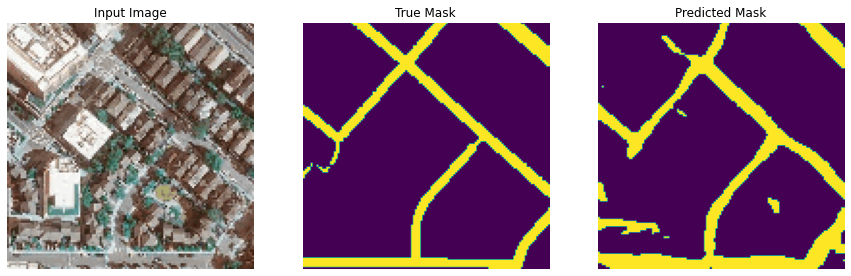

1/1 [==============================] - 0s 20ms/step


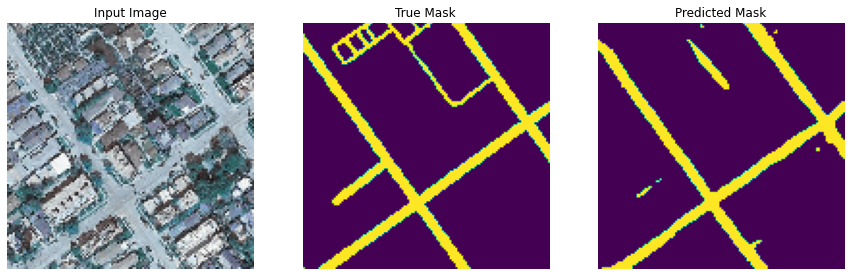

1/1 [==============================] - 0s 21ms/step


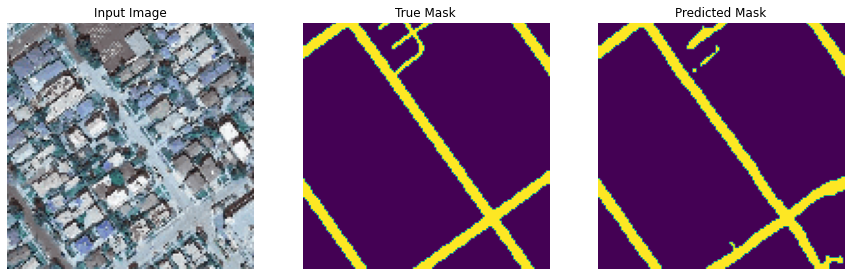

1/1 [==============================] - 0s 19ms/step


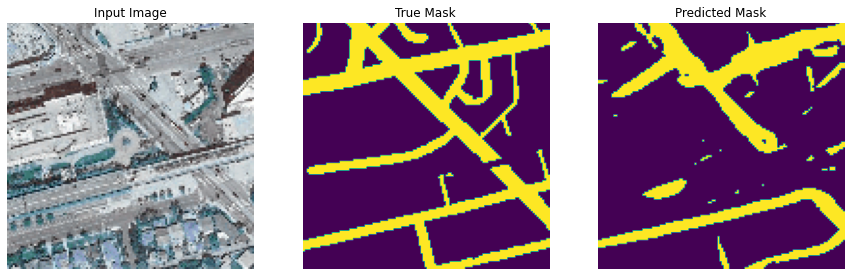

1/1 [==============================] - 0s 20ms/step


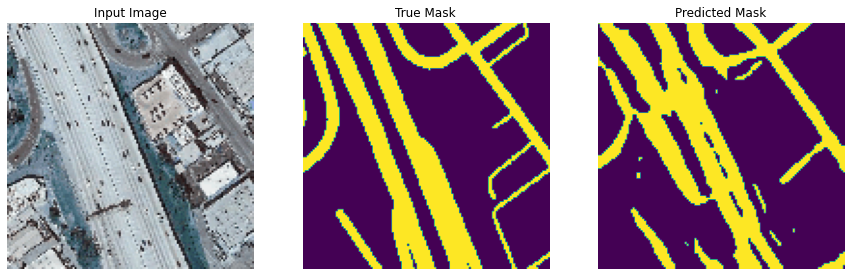

In [22]:
show_predictions(validation_batches, 5)